# Load and Examine Data

Here we will load the digits from [ICDAR 2005 Robust Reading Competetion](http://www.iapr-tc11.org/mediawiki/index.php/ICDAR_2005_Robust_Reading_Competitions) dataset. Letters are also available for download.

It is in "mnist format" (also called "IDX" in some places) which is not an especially common format. I found a short function that will load it- I haven't looked into how this works, but the results below show that it *does* work so I'm not going to spend time figuring it out.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# a function for reading mnist-format files
# https://gist.github.com/tylerneylon/ce60e8a06e7506ac45788443f7269e40

import struct

def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [3]:
# read image and label files
digits = read_idx('data/digit_images.bin')
labels = read_idx('data/digit_labels.bin')

# data should be nx28x28 and labels should be nx1
digits.shape, labels.shape

((988, 28, 28), (988,))

In [4]:
# check how many unique labels there are- should be 10.
# also check what the actual labels are
print(len(np.unique(labels)), [l for l in np.unique(labels)])

10 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


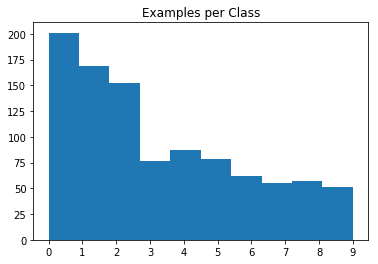

In [5]:
# check class balance
plt.hist(labels)
plt.title('Examples per Class')
plt.xticks(np.unique(labels));

In [6]:
# check the range of the pixel values- by specification it should be [0, 255]
# but this is pretty important to be sure about.
print(digits.min(), digits.max(), np.median(digits))

0 254 125.0


Next, check general aspects of the imported data and plot some random examples and their labels to be sure that the data actually did load as expected.

A note on colormaps (`cmap` parameter on imshow). I *strongly* recommend using only [perceptually uniform](https://peterkovesi.com/projects/colourmaps/) colormaps. Rainbow colormap is a plague, don't use it. [Matplotlib colormaps](https://matplotlib.org/examples/color/colormaps_reference.html) include `viridis`, `plasma`, `inferno`, and `magma`.

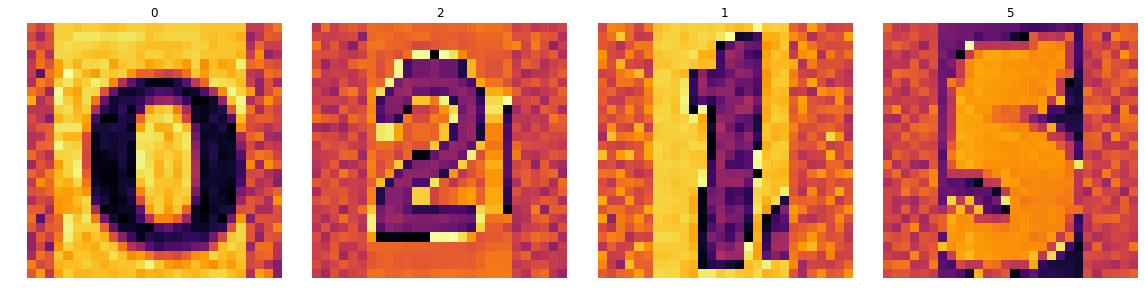

In [7]:
# run multiple times to see different images

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,4))

for ax in axes:
    idx = np.random.randint(0, len(digits))
    ax.imshow(digits[idx], cmap ='inferno')
    ax.set_title(labels[idx])
    ax.axis('off')
    
fig.tight_layout()

# Prepare Data for Training

### One-Hot encoding
The labels will need to be one-hot-encoded. There are [many](https://www.tensorflow.org/api_docs/python/tf/one_hot) [alternative](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical) ways to do this, but I chose [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

### Data reshaping
There is also some reshaping of the arrays going on that might confuse you. The shape of the labels is (n,) but OneHotEncoder will throw an error. We must reshape to (n, 1). The `[..., np.newaxis]` business is a way of adding another axis to the end array. There are also [other](https://stackoverflow.com/a/945313) ways to do this. If we did `[np.newaxis, ...]` we would get the axis at the beginning, ie (1, n).

The shape of the images is (n, 28, 28) but convolutional layers need a "depth" component. Thus, we need (n, 28, 28, 1). Later, when we want to predict on a single image, we will have an array of (28, 28) but will need to use the same method to reshape it into (1, 28, 28, 1).

### Train-Test Split
When we do a train-test-split, we saw above that our classes are not well-balanced in the original data and some have vewy few examples. We therefore want to ensure class balance by using the `stratify` parameter in [sklearn's train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). We can pass the original integer labels for this. I originally didn't do this, but after adding it I saw serious accuracy improvement on both "test" data and my own images.

A note on random states. Setting a random state ensures reproducability. On some things it's a judgement call of if you care or not, but when it comes to train / test split you really want to be consistent.

### Data Augmentation
Our dataset is pretty small. Keras [includes](https://keras.io/preprocessing/image/) some great preprocessing tools for images that includes some augmentation options. There are many different suggestions for how to handle the pixel value range for images. I decided not to do any adjustments here, but rather to do them within the model itself.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [9]:
labels_ohe = OneHotEncoder(categories='auto').fit_transform(labels[..., np.newaxis])

digits = digits[..., np.newaxis]

X_train, X_test, y_train, y_test = train_test_split(digits, labels_ohe, stratify=labels, random_state=42)

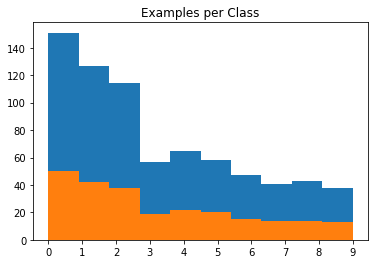

In [10]:
# check class balance
plt.hist(np.argmax(y_train, axis=-1))
plt.hist(np.argmax(y_test, axis=-1))
plt.title('Examples per Class')
plt.xticks(np.unique(labels));

In [11]:
# make data augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    zoom_range = (0.8, 1.1),
    rotation_range = 30,
    brightness_range= (1.5, 0.5),
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = False,
    vertical_flip = False
)

Using TensorFlow backend.


# Make Keras Model

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, Dense, InputLayer, Flatten, MaxPool2D, BatchNormalization, Lambda, GaussianNoise
from keras import backend as K
from keras.optimizers import Adam

In [13]:
from livelossplot.keras import PlotLossesCallback

In [14]:
def build_model(n_classes=10):

    droprate = 0.25

    model = Sequential()
    model.add(InputLayer(input_shape=(28, 28, 1)))
    model.add(Lambda(lambda x: ((x - K.min(x))) * (255/(K.max(x)-K.min(x)))))
    model.add(GaussianNoise(0.01))
    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(droprate))
    model.add(MaxPool2D())

    model.add(Conv2D(64, (3,3), padding='same', activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(droprate))
    model.add(MaxPool2D())

    model.add(Conv2D(128, (3,3), padding='same', activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(droprate))
    model.add(MaxPool2D())

    model.add(Conv2D(256, (3,3), padding='same', activation='relu', kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Dropout(droprate))
    model.add(MaxPool2D())

    model.add(Flatten())
    model.add(Dense(n_classes, activation='softmax', kernel_regularizer='l2'))
    

    model.compile(optimizer=Adam(amsgrad=True), loss='categorical_crossentropy', metrics=['acc'])
    
    model.summary()
    
    return model

In [15]:
model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
__________

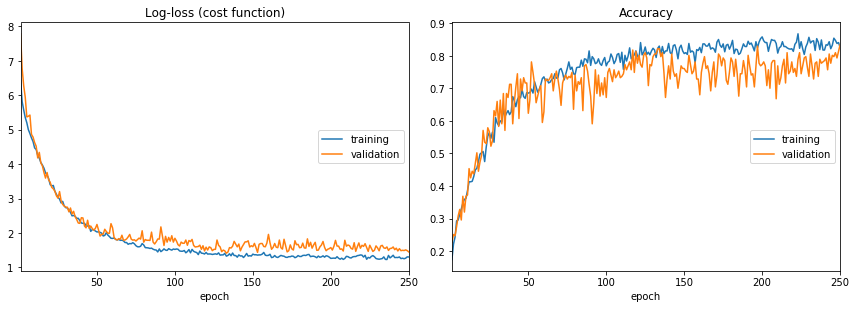

Log-loss (cost function):
training   (min:    1.231, max:    6.440, cur:    1.305)
validation (min:    1.415, max:    7.787, cur:    1.453)

Accuracy:
training   (min:    0.174, max:    0.868, cur:    0.826)
validation (min:    0.227, max:    0.834, cur:    0.834)


In [16]:
history = model.fit_generator(datagen.flow(X_train, y_train.toarray(), batch_size=64),
                              epochs=250,
                              validation_data=(X_test, y_test),
                              callbacks=[PlotLossesCallback()],
                              verbose=0)

# Evaluate on New Image

In [17]:
import cv2

In [18]:
def predict_on_file(filename, model):
    img = cv2.imread(filename)
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_grey, dsize=(28, 28))
       
    prediction = model.predict(img_resized[np.newaxis, ..., np.newaxis])[0]
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    
    axes[0].imshow(img);
    axes[0].axis('off')
    axes[0].set_title('Original')

    
    img_range = img_resized.max() - img_resized.min()
    img_rescaled = (img_resized - img_resized.min()) * (255/img_range)

    axes[1].imshow(img_rescaled, cmap='gray');
    axes[1].axis('off')
    axes[1].set_title('Input to Model')

    
    axes[2].bar(x=range(0,10), height=prediction)
    axes[2].xaxis.set_ticks(np.arange(0, 10, 1))
    axes[2].set_title('Prediction: {}'.format(np.argmax(prediction)))
    axes[2].axvline(np.argmax(prediction), c='red')
    axes[2].set_ylim(0, 1.0)
    
    plt.tight_layout()
    
    return prediction

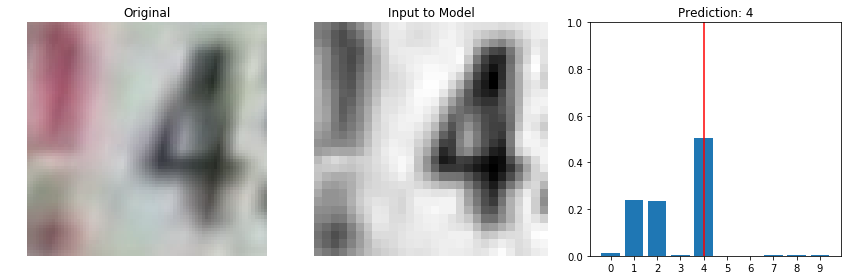

In [22]:
a1 = predict_on_file('test_images/4.png', model)

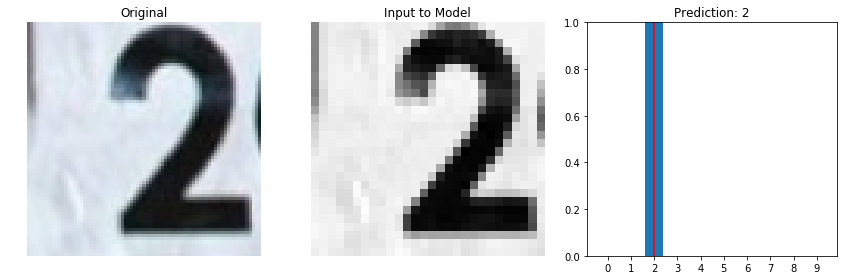

In [23]:
a2 = predict_on_file('test_images/2.png', model)

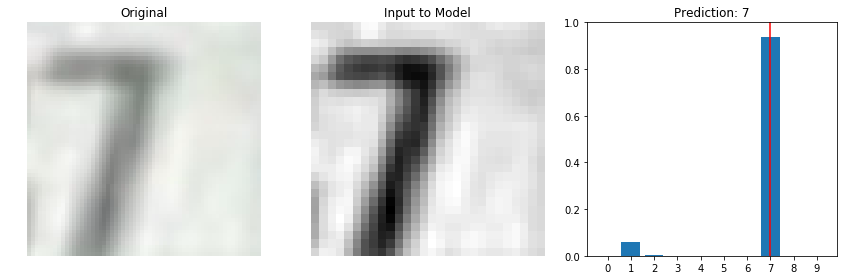

In [24]:
a3 = predict_on_file('test_images/7.png', model)